# Join 平台眾開講

Things tried so far:

* Simple deep dense model
* A simple CNN

A few things to try next:

* Split data to sentences and re-label them.  Remove duplicated data.  Remove URLs, tagging users, ～ 👍.
* RNN, since the comments tend to be short and paragraph-less.
* LRP to explain classifications
* fastText

## Setup

In [5]:
path = "data/join"
topic = "立法方式保障"
# topic = "同性伴侣法"
# topic = "同性婚姻法"

In [6]:
from __future__ import division, print_function
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import jieba
from keras.models import Sequential
from keras.layers import Embedding, Dense, Flatten, Dropout, BatchNormalization, Conv1D, ZeroPadding1D
import os, math, re

jieba.set_dictionary(os.path.join("data", "dict.txt.big"))

Read in messages from CSV.

In [17]:
def get_sentences(fn):
    for message in pd.read_csv(os.path.join(fn), index_col=0).content:
        for sentence in re.split(r"(?:。|？|！|\.|\?|!)+", message):
            if len(sentence) > 0:
                yield sentence

with open(os.path.join(path, topic + "-sentences.txt"), "w") as fh:
    fh.writelines([ s + "\n" for s in get_sentences(os.path.join(path, topic + ".csv")) ])

In [101]:

def get_messages_from_orig(topic):
    messages = pd.read_csv(os.path.join(path, topic + ".csv"), index_col=0)
    mask = messages.astype('str').applymap(lambda x: len(x.decode('utf-8'))).content > 20
    messages = messages[mask]
    messages.to_csv(os.path.join(path, topic + "-good.csv"))
    return messages

def get_labeled_messages(topic):
    return pd.read_csv(os.path.join(path, topic + "-good.csv"), index_col=0)

def labeled_only(messages):
    return messages[messages.ORID.notnull()]

def unlabeled_only(messages):
    return messages[messages.ORID.isnull()]
    
all_messages = get_messages_from_orig(topic) if not os.path.exists(os.path.join(path, topic + "-good.csv")) \
                                         else get_labeled_messages(topic)
messages = labeled_only(all_messages)

Build dictionary of phrases and load word embeddings.

In [102]:
def write_dictionary(messages):
    contents = [ jieba.lcut(c) for c in messages.content ]
    all_phrases = set([ ph for c in contents for ph in c ])
    with open(os.path.join(path, "dictionary.txt"), "w") as fh:
        for ph in all_phrases:
            fh.write(ph.encode("utf-8") + "\n")
            
def read_dictionary():
    dictionary = pd.read_csv(os.path.join(path, "dictionary.vec"), 
                       delim_whitespace=True, engine="python", header=None, index_col=0)
    return dictionary

if not os.path.exists("dictionary.vec"):
    write_dictionary(all_messages)
    !cd data/join; ../../../bin/fasttext print-word-vectors models/wiki.zh.bin < dictionary.txt > dictionary.vec
dictionary = read_dictionary()

Building prefix dict from /Users/pm5/src/trustableai/ggv-example/nbs/dict.txt.big ...
Loading model from cache /var/folders/sy/q12w5xyn4lngqxh_j63vwr4h0000gn/T/jieba.u9dd8a37c223dc739fc5b291951ecdf95.cache
Loading model cost 1.097 seconds.
Prefix dict has been built succesfully.


Build dictionary index to convert phrases into embedding vectors.

In [103]:
dict_index = { ph.decode("utf-8"): i for i, ph in enumerate(dictionary.index) }

Split messages into training and validation datasets by 4:1.

In [104]:
select = np.random.random(len(messages)) < 0.8
train = messages[select]
valid = messages[~select]

Show the data.

In [105]:
print("Total messages: {count}".format(count=len(all_messages)))
print("Labeled messages: {count}".format(count=len(messages)))
messages.head()

Total messages: 10215
Labeled messages: 277


,createDate,authorName,content,ORID,comments
id,,,,,
14136,2015-08-03 8:57:21,Shaffer Lin,「政府對全體人民的人權有履行義務且不應以公眾之意見作為履行的條件」那現在在投什麼？自打嘴巴？...,R,NaN
14135,2015-08-03 9:30:52,Oliver Lin,贊成歸贊成但更贊成就直接修民法就好了不用疊床架屋我要的沒有比較特別就是現在一堆人在結的那個婚姻,D,NaN
14134,2015-08-03 10:05:26,蛍一 森里,與其以立法的方式來保障不如用修法的方式來保障不是比較方便一些?,I,NaN
14133,2015-08-03 10:08:00,楊剛,投你個花開富貴啦我要不要結婚關順性別異性戀沙豬什麼事啊？啊連個草案都沒有的東西是要投三小喔？...,R,NaN
14132,2015-08-03 10:14:57,黑桐喵,原來別人要不要結婚須要所有人一起投票決定。既然都說了「政府對全體人民的人權有履行義務且不應以...,R,NaN


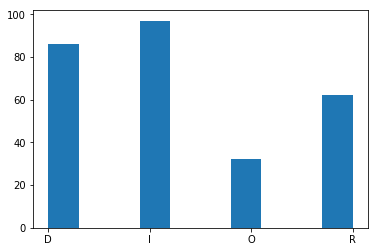

In [106]:
plt.hist(messages.ORID.values)
plt.show()

In [107]:
dictionary.shape, dict_index[u"同性"], (dictionary.iloc[dict_index[u"同性"]] == dictionary.loc["同性"]).all()

((35700, 300), 27872, True)

In [108]:
dictionary

,1,2,3,4,5,6,7,8,9,10,...,291,292,293,294,295,296,297,298,299,300
0,,,,,,,,,,,,,,,,,,,,,
涉,-0.150730,0.065861,-0.170880,0.140670,0.080244,0.275180,-0.015360,0.136730,-0.031647,-0.179470,...,0.123640,1.406300,0.740890,0.150450,-0.649560,0.908700,0.511870,-0.118130,-0.229440,0.674610
第二,-0.192220,-0.267540,-0.120930,-0.206320,-0.030720,-0.437130,0.039571,-0.279030,0.124740,0.391830,...,-0.183750,0.337130,0.991730,0.116610,-0.490460,0.283860,1.254000,-0.160880,-0.318320,0.443320
明確,0.081849,-0.132240,0.068349,0.011674,0.052534,-0.334550,-0.037619,-0.316560,0.107180,0.162850,...,-0.519650,0.980540,0.334560,0.307540,-0.049831,0.208090,0.884190,-0.541420,0.536490,0.186220
mbasic,0.253650,-0.720360,-0.366840,-0.036221,-0.099699,-0.045213,0.071017,0.228460,0.067062,-0.068417,...,-0.673650,-0.293350,-0.050524,0.109900,0.058742,-0.183750,0.326130,0.263570,0.682770,0.628380
為妻,0.095707,0.012151,0.115030,0.241860,-0.107400,-0.255950,-0.015413,-0.181650,-0.037391,0.055197,...,-0.284110,0.787440,0.738190,0.310750,-0.277570,0.512140,0.526000,-0.095938,0.358630,0.157560
小腳,-0.204720,-0.069370,0.020854,0.259190,0.520370,-0.140560,-0.079038,-0.157280,-0.004681,0.072783,...,-0.291900,0.637060,0.594160,0.439250,-0.413150,0.478180,0.391010,0.127890,0.054824,-0.109120
追隨,0.314080,0.336170,0.131690,0.107460,-0.154770,-0.191150,0.191530,0.012053,-0.067136,-0.123820,...,-0.411890,0.652340,0.105040,-0.243220,-0.638360,0.449890,1.147000,-0.243540,0.166520,0.314970
神為,-0.116880,-0.150410,0.014156,0.060975,-0.077271,-0.247400,0.301440,-0.223270,0.046785,0.453310,...,-0.286650,1.174900,0.514990,0.355620,-0.204290,0.680990,0.778920,-0.455160,-0.015183,0.572770
這太,-0.108450,-0.232520,-0.153010,-0.094482,0.197290,-0.408100,-0.022546,-0.341260,0.077701,0.019138,...,-0.288920,0.751180,0.689670,0.335140,-0.430550,0.497550,0.637760,-0.094301,-0.148630,0.253920


In [109]:
print("Training data: {count}".format(count=len(train)))
train.head()

Training data: 229


,createDate,authorName,content,ORID,comments
id,,,,,
14136,2015-08-03 8:57:21,Shaffer Lin,「政府對全體人民的人權有履行義務且不應以公眾之意見作為履行的條件」那現在在投什麼？自打嘴巴？...,R,NaN
14135,2015-08-03 9:30:52,Oliver Lin,贊成歸贊成但更贊成就直接修民法就好了不用疊床架屋我要的沒有比較特別就是現在一堆人在結的那個婚姻,D,NaN
14134,2015-08-03 10:05:26,蛍一 森里,與其以立法的方式來保障不如用修法的方式來保障不是比較方便一些?,I,NaN
14133,2015-08-03 10:08:00,楊剛,投你個花開富貴啦我要不要結婚關順性別異性戀沙豬什麼事啊？啊連個草案都沒有的東西是要投三小喔？...,R,NaN
14132,2015-08-03 10:14:57,黑桐喵,原來別人要不要結婚須要所有人一起投票決定。既然都說了「政府對全體人民的人權有履行義務且不應以...,R,NaN


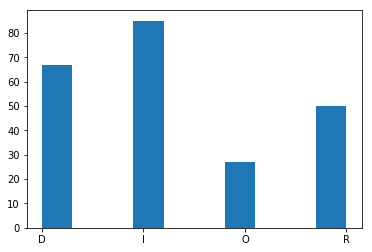

In [110]:
plt.hist(train.ORID.values)
plt.show()

In [111]:
print("Validation data: {count}".format(count=len(valid)))
valid.head()

Validation data: 48


,createDate,authorName,content,ORID,comments
id,,,,,
14117,2015-08-03 18:52:10,Allen Dai,"A marriage is a marriage, not ""gay marriage."" ...",D,NaN
14114,2015-08-03 23:49:24,Ato Otto,民法修正才是真平等。令修專法給同性戀者，反而是一種歧視性的隔離政策。,D,NaN
14112,2015-08-04 2:22:18,Lih-woei Chen,講的太好了，婚姻就是婚姻，不該因族群而有分別。法務部訂這個標題就跟「是否同意設立新移民專屬婚...,R,NaN
14111,2015-08-04 2:40:16,Shinyng Huang,不知去哪找這樣的人才可以寫出這樣充滿歧視的命題,R,NaN
14094,2015-08-04 4:43:11,He Cheng-xuan,這是動亂嗎？而且看清楚，他拒絕賣花給要舉辦「同性婚禮」的人。是「婚禮」喔。所以現在要是有人舉...,I,NaN


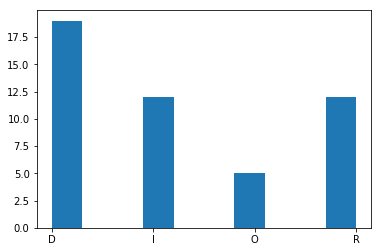

In [112]:
plt.hist(valid.ORID.values)
plt.show()

Setup input length and word embeddings.

In [113]:
input_length = 140

def create_embeddings(dictionary, input_length=100):
    phrases, latents = dictionary.shape
    embedding = Embedding(phrases, latents, input_length=input_length, weights=[dictionary])
    return embedding

In [114]:
def get_data(messages):
    jieba_cut = np.frompyfunc(lambda x: [ ph for ph in jieba.lcut(x.decode("utf-8")) if ph != u" " ][:input_length], 1, 1)
    word_embed = np.frompyfunc(lambda x: [ dict_index[ph] for ph in x ], 1, 1)
    fill_to_length = np.frompyfunc(lambda x: x + [0] * (input_length - len(x)), 1, 1)
    return np.stack(fill_to_length(word_embed(jieba_cut(messages.content.values))), axis=0)

answers_oh = { "O": [1., 0., 0., 0.], "R": [0., 1., 0., 0.], "I": [0., 0., 1., 0.], "D": [0., 0., 0., 1.] }

def orid_to_oh(x): return answers_oh[x]

def get_answer(messages):
    return np.array([ orid_to_oh(x) for x in messages.ORID ])

train = (get_data(train), get_answer(train))
valid = (get_data(valid), get_answer(valid))

In [115]:
train[0][10], train[1][10], valid[0][0], valid[1][0]

(array([22863,  8028,  3247, 26432, 27872,  2431, 13981,  4337,  3521,
        12786, 31545, 33938,  1534, 16517, 35226, 22140, 28135, 29856,
         3521,  8921, 30222, 35511, 21702,  9131, 13758,  6807,  6807,
        22308,  6634,  8028,  2626,  8028,  3247, 26432, 17316, 12362,
        31545, 33938,  3345, 22114, 15574,  4710, 31545,  4616, 32465,
        27118,   839, 22749, 13981,  7426,  8028, 18243,  8028,  2082,
        12275,  3326,  4710, 16517,  7774,  8028,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
      

# Single hidden layer model

In [127]:
batch_size = 64

def simple_nn_model():
    model = Sequential()
    model.add(create_embeddings(dictionary, input_length))
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dense(256, activation="relu"))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())
    model.add(Dense(256, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(4, activation="softmax"))
    return model

simple_nn = simple_nn_model()
simple_nn.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_24 (Embedding)         (None, 140, 300)      10710000    embedding_input_24[0][0]         
____________________________________________________________________________________________________
flatten_12 (Flatten)             (None, 42000)         0           embedding_24[0][0]               
____________________________________________________________________________________________________
batchnormalization_36 (BatchNorm (None, 42000)         168000      flatten_12[0][0]                 
____________________________________________________________________________________________________
dense_23 (Dense)                 (None, 256)           10752256    batchnormalization_36[0][0]      
___________________________________________________________________________________________

In [128]:
simple_nn.compile("adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [129]:
def train_simple_nn(lr=None, epoch=1):
    if lr is not None:
        simple_nn.optimizer.lr = lr
    simple_nn.fit(train[0], train[1], nb_epoch=epoch, validation_data=valid, batch_size=batch_size)


In [130]:
train_simple_nn()
train_simple_nn(lr=1e-1, epoch=2)
train_simple_nn(lr=1e-4, epoch=2)

Train on 229 samples, validate on 48 samples
Epoch 1/1
229/229 [==============================] - 4s - loss: 1.9536 - acc: 0.3057 - val_loss: 4.1164 - val_acc: 0.1458
Train on 229 samples, validate on 48 samples
Epoch 1/2
229/229 [==============================] - 2s - loss: 1.2372 - acc: 0.4978 - val_loss: 2.4654 - val_acc: 0.2917
Epoch 2/2
229/229 [==============================] - 2s - loss: 1.1794 - acc: 0.5197 - val_loss: 2.0777 - val_acc: 0.3333
Train on 229 samples, validate on 48 samples
Epoch 1/2
229/229 [==============================] - 2s - loss: 1.0414 - acc: 0.5677 - val_loss: 1.6665 - val_acc: 0.1875
Epoch 2/2
229/229 [==============================] - 2s - loss: 0.9333 - acc: 0.6288 - val_loss: 1.8916 - val_acc: 0.2500


# CNN

In [131]:
batch_size = 64

def cnn_model():
    model = Sequential()
    model.add(create_embeddings(dictionary, input_length))
    model.add(BatchNormalization())
    model.add(Conv1D(128, 7, border_mode="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(Conv1D(128, 7, border_mode="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(10))
    model.add(Dropout(0.5))
    model.add(Dense(4, activation="softmax"))
    return model

cnn = cnn_model()
cnn.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_25 (Embedding)         (None, 140, 300)      10710000    embedding_input_25[0][0]         
____________________________________________________________________________________________________
batchnormalization_38 (BatchNorm (None, 140, 300)      1200        embedding_25[0][0]               
____________________________________________________________________________________________________
convolution1d_30 (Convolution1D) (None, 140, 128)      268928      batchnormalization_38[0][0]      
____________________________________________________________________________________________________
batchnormalization_39 (BatchNorm (None, 140, 128)      512         convolution1d_30[0][0]           
___________________________________________________________________________________________

In [132]:
cnn.compile("adam", loss="categorical_crossentropy", metrics=["accuracy"])

def train_cnn(lr=None, epoch=1):
    if lr is not None:
        cnn.optimizer.lr = lr
    cnn.fit(train[0], train[1], nb_epoch=epoch, validation_data=valid, batch_size=batch_size)

In [133]:
train_cnn()
train_cnn(0.01, 8)

Train on 229 samples, validate on 48 samples
Epoch 1/1
229/229 [==============================] - 5s - loss: 6.6229 - acc: 0.2620 - val_loss: 4.9207 - val_acc: 0.1875
Train on 229 samples, validate on 48 samples
Epoch 1/8
229/229 [==============================] - 3s - loss: 8.7130 - acc: 0.2882 - val_loss: 9.1436 - val_acc: 0.2500
Epoch 2/8
229/229 [==============================] - 3s - loss: 9.3783 - acc: 0.3013 - val_loss: 9.8090 - val_acc: 0.2500
Epoch 3/8
229/229 [==============================] - 3s - loss: 9.1775 - acc: 0.3188 - val_loss: 10.5652 - val_acc: 0.2500
Epoch 4/8
229/229 [==============================] - 4s - loss: 8.3444 - acc: 0.3406 - val_loss: 10.1911 - val_acc: 0.3333
Epoch 5/8
229/229 [==============================] - 4s - loss: 8.2191 - acc: 0.3406 - val_loss: 9.5382 - val_acc: 0.3333
Epoch 6/8
229/229 [==============================] - 4s - loss: 8.1177 - acc: 0.3712 - val_loss: 10.5349 - val_acc: 0.2083
Epoch 7/8
229/229 [==============================] - 

# Evaluation

In [134]:
#model = simple_nn
model = cnn

In [140]:
results = unlabeled_only(all_messages).copy()
test_data = get_data(results)
pred = model.predict(test_data, batch_size=batch_size)
orid_fn = np.frompyfunc(lambda x, m: ["O", "R", "I", "D"][x]  if m > 0.6 else "", 2, 1)
pred_orid = orid_fn(np.argmax(pred, axis=1), np.max(pred, axis=1))
results.loc[:, "prediction"] = pd.Series(pred_orid, index=results.index)
results

,createDate,authorName,content,ORID,comments,prediction
id,,,,,,
14138,2015-08-03 8:12:21,小K,那麼亞洲國家的現況呢？以新加坡或日本這兩個已開發的國家來說，是否有進行相關政策？,NaN,NaN,O
14110,2015-08-04 2:41:32,Oliver Lin,你搞錯了，不論性向有錢人是最不受制度限制的一群人如果你擔心這點，請採用共產制度根本上讓大家均貧就好,NaN,NaN,O
14103,2015-08-04 3:43:13,in.j li,"你(妳)知道性取向是天生的,那試問, 如果自然法則是同性交配才能繁殖下一代, 那你(妳)可以...",NaN,NaN,I
14097,2015-08-04 4:29:26,black756133,無神論者無法相信任何沒有存在證據的神說的話，跟神溝通也只能透過古代人編寫的各種版本同人作品自...,NaN,NaN,R
14096,2015-08-04 4:33:21,RED,冰山一角http://news.ltn.com.tw/news/wo...,NaN,NaN,O
14088,2015-08-04 5:21:16,RED,網路很多新聞，平時你不看的那種。https://chinesemanif.wordpress...,NaN,NaN,O
14071,2015-08-04 6:40:52,葉佩君,生病血型怨天尤人無醫生醫治。小孩到家庭社會官誰負責。輔導有同性戀傾向與一救醫院協助同性戀我們...,NaN,NaN,O
14067,2015-08-04 6:48:32,Tsuyoshi Kusae,閣下真的好傻好天真，難怪不必講什麼大道理，講了你大概也不會懂。老子我天生愛男人可不是誰去鼓勵...,NaN,NaN,R
14066,2015-08-04 6:49:24,葉佩君,主題有點不清不楚。按讚是不要修改一夫一妻。還是讚成不要同性戀結婚。,NaN,NaN,O


In [146]:
results[results.prediction == "O"]

,createDate,authorName,content,ORID,comments,prediction
id,,,,,,
14138,2015-08-03 8:12:21,小K,那麼亞洲國家的現況呢？以新加坡或日本這兩個已開發的國家來說，是否有進行相關政策？,NaN,NaN,O
14110,2015-08-04 2:41:32,Oliver Lin,你搞錯了，不論性向有錢人是最不受制度限制的一群人如果你擔心這點，請採用共產制度根本上讓大家均貧就好,NaN,NaN,O
14096,2015-08-04 4:33:21,RED,冰山一角http://news.ltn.com.tw/news/wo...,NaN,NaN,O
14088,2015-08-04 5:21:16,RED,網路很多新聞，平時你不看的那種。https://chinesemanif.wordpress...,NaN,NaN,O
14071,2015-08-04 6:40:52,葉佩君,生病血型怨天尤人無醫生醫治。小孩到家庭社會官誰負責。輔導有同性戀傾向與一救醫院協助同性戀我們...,NaN,NaN,O
14066,2015-08-04 6:49:24,葉佩君,主題有點不清不楚。按讚是不要修改一夫一妻。還是讚成不要同性戀結婚。,NaN,NaN,O
14061,2015-08-04 6:53:25,Candu Hol,異性戀納粹，歷史會告訴你，有一天你會恨不得把現在的自己砍掉重練，哈哈哈。,NaN,NaN,O
14057,2015-08-04 6:54:40,葉佩君,生病血型要輸入醫生如何處理。要自己負責。處理要三思 而後行。,NaN,NaN,O
14055,2015-08-04 6:57:23,葉佩君,後悔還可以。到時候怨天尤人。誰會幫助同性戀人。耶穌基督醫治釋放台灣同性戀人。,NaN,NaN,O


In [142]:
results[results.prediction == "R"]

,createDate,authorName,content,ORID,comments,prediction
id,,,,,,
14097,2015-08-04 4:29:26,black756133,無神論者無法相信任何沒有存在證據的神說的話，跟神溝通也只能透過古代人編寫的各種版本同人作品自...,NaN,NaN,R
14067,2015-08-04 6:48:32,Tsuyoshi Kusae,閣下真的好傻好天真，難怪不必講什麼大道理，講了你大概也不會懂。老子我天生愛男人可不是誰去鼓勵...,NaN,NaN,R
14033,2015-08-04 7:22:59,沒邏輯,"因為,同性婚姻一過,會有一堆人辦婚禮,然後婚紗店老闆與飯店賺太多,老闆們太開心,所以中風了;...",NaN,NaN,R
14030,2015-08-04 7:29:14,宋天浩,敬愛的主、慈愛的天父，請您原諒葉s亂以主耶穌之名惑亂民眾耳目，祈望主能開啟葉s的智慧。也請主...,NaN,NaN,R
14027,2015-08-04 7:31:09,James Chen,是非題題目:是否贊成以立法方式，給予同性戀者「類似婚姻」或「婚姻」關係，以保障其權利及法律地...,NaN,NaN,R
14018,2015-08-04 7:40:06,Pun Lee,你以為你是異性戀你就不會得到愛滋？！如果你還嫁的出去最好看緊你自己的老公 有本事的男人最厲害...,NaN,NaN,R
14012,2015-08-04 7:47:18,葉佩文,"你應該問他的是: 請問對於一改再改的教育與考試,還有30秒通過的服貿有何看法;何況健保最大支...",NaN,NaN,R
14010,2015-08-04 7:49:12,洪國章,實在是完全搞不懂扯到動物去的想法到底是腦袋哪裡出了問題……好吧！既然你提了婚姻是甚麼這個問題...,NaN,NaN,R
14001,2015-08-04 7:56:38,Oliver Lin,講話謹慎點真的要自費就來自費看看到時候會有多少異性戀患者崩潰對了，你知道服藥性差就會讓病情加...,NaN,NaN,R


In [143]:
results[results.prediction == "I"]

,createDate,authorName,content,ORID,comments,prediction
id,,,,,,
14103,2015-08-04 3:43:13,in.j li,"你(妳)知道性取向是天生的,那試問, 如果自然法則是同性交配才能繁殖下一代, 那你(妳)可以...",NaN,NaN,I
14048,2015-08-04 7:04:06,請支持,1.請提出愛滋病與同志婚姻的關係? 2.你以為愛滋病毒找宿主時會區宗教與性取向? 3. 你知...,NaN,NaN,I
14045,2015-08-04 7:14:18,Andward Peng,同性戀結婚了，異性戀還是生小孩，過自己的生活，影響國家 什麼的利益? 【子宮頸癌】 ，照你...,NaN,NaN,I
14005,2015-08-04 7:54:39,Pun Lee,異性戀有本事就一輩子將陰道交進行到底 異性戀也不准自慰還有最重要的是異性戀在進行陰道交的時候...,NaN,NaN,I
14003,2015-08-04 7:56:05,許詠銓,那你為甚麼可以結婚!!!那也是你的個人權利阿~妳老公外遇也是他的個人權利為甚麼你要生氣既然是...,NaN,NaN,I
13963,2015-08-04 8:48:24,Jesus,看完留言，覺得應該限制的是宗教自由...反對的根本只是針對「同性」一直強調一夫一妻多神聖陶喆...,NaN,NaN,I
13961,2015-08-04 8:49:18,Li S En,互相攻擊只會中招 官員就是讓同性跟異性這樣互相攻擊 兩性平等 應該要互助 異性...,NaN,NaN,I
13948,2015-08-04 9:11:57,感謝按下贊成的各位,"感謝這們多人願意站在歷史對的一方,也願意重視人權,同志爭的婚姻平權,不只是在於名稱,而是希望...",NaN,NaN,I
13920,2015-08-04 9:40:31,Michael,我是来自大陆的一名网友，看了这个调查，其实真的挺羡慕台湾朋友的。要知道在大陆，政府从来都对社...,NaN,NaN,I


In [144]:
results[results.prediction == "D"]

,createDate,authorName,content,ORID,comments,prediction
id,,,,,,
13989,2015-08-04 8:05:19,john liou,"那你應該問你父母對於生下同志兒女的看法,很少會有人接受的,因為這與當時他們結婚的想法及願望是...",NaN,NaN,D
13766,2015-08-04 13:04:32,洪國章,愛是恆久忍耐，又有恩慈；愛是不嫉妒，愛是不自誇不張狂，不做害羞的事，不求自己的益處，不輕易發...,NaN,NaN,D
13750,2015-08-04 13:34:07,洪國章,"這段話真的讓我笑了許久，請讓我帶著笑意回覆你的論述。你說：「因為現在他們還""被不接受""所以有...",NaN,NaN,D
13654,2015-08-04 15:11:31,Victor Cheng,"你現在用電腦上網打字..... 是有""自然""到哪去？ 地球上的物種有八成在大自然中會發生同性...",NaN,NaN,D
13591,2015-08-04 16:16:18,Nelson,"看了好多遍，從""選擇""同性相愛到""人倫混亂""最後是""危害雙親""，除了滿頭的問號外，我想試問你...",NaN,NaN,D
13551,2015-08-04 16:45:23,劉一守,同性戀可以不要繳稅嗎？如果可以不繳稅那就不用立這法啦!!為啥繳稅沒分同性異性，法律保障的卻分...,NaN,NaN,D
13505,2015-08-04 17:19:25,劉一守,同性戀可以不要繳稅嗎？如果可以不繳稅那就不用立這法啦!!為啥繳稅沒分同性異性，法律保障的卻分...,NaN,NaN,D
13488,2015-08-04 17:36:13,劉一守,政府的經濟來源不就是人民的納稅錢嗎？如果政府都不保障我們權利了，那為何我們還要提供我們的收入...,NaN,NaN,D
13222,2015-08-04 20:31:18,KEN KEN,第1個謬誤：支持同性婚姻實務上的確切理由是「法律上的權益和保障」，而不是你講的表面因素而已所...,NaN,NaN,D
